# Let's see an example first!

In [1]:
# some libraries we need for this experiment, you can import anything else as you like.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import leastsq
from numdifftools import Jacobian
pi = np.pi

## Fit an ellipse... 

### We provide 753 3d points with noise and you should fit an ellipse with these data points.

In [2]:
# We always see the data first to understand what we are doing.
data = np.loadtxt('data.txt')
print(data)
print(data.shape)

[[-1.7479  -1.2471  -0.97522]
 [ 0.87797  0.26425  1.7506 ]
 [-0.56663  1.6488  -0.75284]
 ...
 [-0.643   -1.1677  -1.6812 ]
 [ 2.4525  -1.5302   0.14267]
 [ 0.75208 -0.70906  1.2997 ]]
(753, 3)


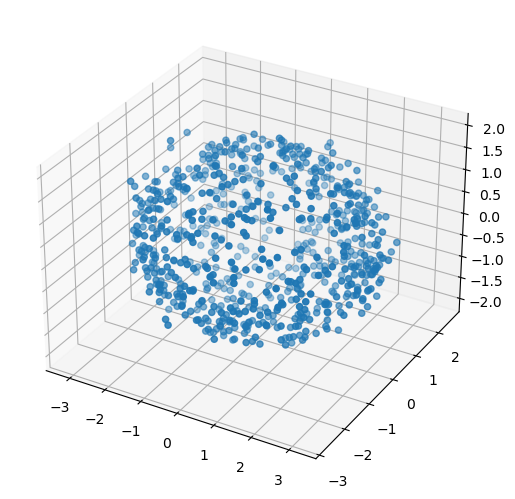

In [3]:
# Sometimes we also need to visualize them.
def _show(x, y, z):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(x, y, z)
    plt.show()
_show(data[:, 0], data[:, 1], data[:, 2])

### The ellipse function is x^2 / A^2 + y^2 / B^2 + z^2 / C^2 = 1

In [4]:
# We define ellipse function.
def func(p, x):
    '''
    p: parameters of the ellipse function;
    x: the 3d space points;
    Return the results of x^2 / A^2 + y^2 / B^2 + z^2 / C^2. We expect it to be 1.
    '''
    a, b, c = p
    return x[:, 0] ** 2 / a ** 2 + x[:, 1] ** 2 / b ** 2 + x[:, 2] ** 2 / c ** 2


# Then define the residual function.
def residual(p, x):
    '''
    p: parameters of the ellipse function;
    x: the 3d space points;
    Return the deviation between the expected result and the result with current parameters.
    '''
    res = func(p, x) - 1
    return res

### We resort to scipy to help us with this problem

In [5]:
# Luckily, scipy has provided functions we need here.
p0 = [1, 1, 1]
result = leastsq(residual, p0, args=(data))
print(result)
params = result[0]

# Least squares method implementation in `scipy`, `leastsq()``: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

(array([2.94404668, 2.30503544, 1.7978253 ]), 1)


In [6]:
# Usually we also check the error of our results.
errors = residual(params, data)
mean_error = np.abs(errors).mean()
print(mean_error)

0.13695362983431605


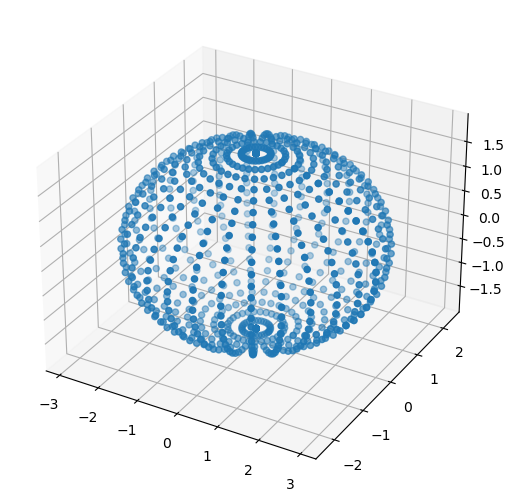

In [7]:
# Let's have a look at what we've gotten here.
def _param_func_show(params, data):
    point_num = 30
    theta = np.linspace(0, pi, point_num)
    fi = np.linspace(0, 2 * pi, point_num)
    x = params[0] * np.sin(theta)[:, np.newaxis] * np.cos(fi)[np.newaxis, :]
    y = params[1] * np.sin(theta)[:, np.newaxis] * np.sin(fi)[np.newaxis, :]
    z = params[2] * np.cos(theta)[:, np.newaxis] * np.ones(point_num)[np.newaxis, :]
    _show(x.reshape(-1), y.reshape(-1), z.reshape(-1))
_param_func_show(params, data)

# It's your turn now!

## Now you are an expert of optimization after the lesson. 
## It's time to solve this problem by yourself!

### You should solve this problem with Gauss-Newton method.
### To help you with this, we have provided some functions you may need.
### If this pipeline restricts you, feel free to implement your own one. But you should add clear comments to your own pipeline to make others understand quickly.

In [8]:
def res(param, data):
    '''
    INPUT:
        param: the parameters you want to optimize
        data: the data you need to fit
    OUTPUT:
        res: the residual of the points with objective function
    '''
    return residual(param, data)


def jacobi(param, data):
    '''
    INPUT:
        param: the parameters you want to optimize
        data: the data you need to fit
    OUTPUT:
        d: the jacobi of the objective function with these data points and parameters
    '''
    return Jacobian( lambda p : res(p, data) )(param).mean(axis=0)



def solve_delta(params, data):
    '''
    INPUT:
        param: the parameters you want to optimize
        data: the data you need to fit
    OUTPUT:
        delta_p: the optimal direction of the parameters
    '''
    J = jacobi(params, data).reshape(1,-1)
    ret = -np.linalg.inv(J.T @ (J)+ 0.1 * np.eye(3)) @ (J.T) * (res(params, data)).mean()
    return ret.reshape(-1)


[2.58375651 2.30009343 2.02415114] 101


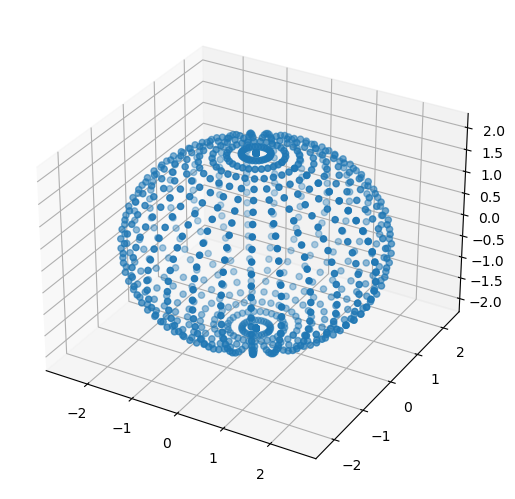

In [9]:
# Choose a start point, maybe [1.0, 1.0, 1.0]? What would happen if you choose a bad start point?
p0 = [1.0, 1.0, 1.0]
k = 0
max_k = 10000
# Choose a good step size!
step = 0.1
# Determine the condition of delta_p
eps = 0.001
p = np.array(p0, dtype=np.float64)
while k < max_k:
    d_p = solve_delta(p, data)
    if np.abs(d_p).mean() < eps:
        # It's enough close to the target.
        break
    p += step * d_p
    k += 1
print(p, k)
_param_func_show(p, k)